# Tool Loadout
Tool Loadout means selecting only the tools that are relevant to the current task and adding their definitions to the model's context. This is done before sending the final input to the model.

In one of the study, it was found that tool overload becomes a real problem beyond 30 tools. Descriptions start to blur and it creates confusion. With more than 100 tools, models like DeepSeek-v3 fail outright. Using RAG to select fewer than 30 tools improved selection accuracy by up to 3x.

Smaller models suffer even sooner. In Less is More, Llama 3.1 8b failed with 46 tools but passed with 19 tools. The issue wasn't the context window, it was confusion from too many options.

To solve this, the team built a tool recommender using an LLM. The model reasoned about what tools it needed, then a semantic search selected the loadout. On the Berkeley Function Calling Leaderboard, this improved Llama 3.1 8b performance by 44%.
Ref:https://arxiv.org/abs/2411.15399

The same paper also found practical benefits:
1. Smaller contexts reduced power use by 18%
2. Speed up inference by 77% , important for edge deployments.

Most agents don't need dozens of tools. But if the tool surface grows, managing the loadout becomes critical.

### Why Tool Loadout is helpful?
Context confusion also appears when we include too many tools. It helps in mitigating context confusion by:
1. Preventing Tool Overlap Confusion: Context confusion appears when many tools are added at once. Their descriptions can overlap, making it unclear which tool the model should choose.
2. Reducing Context Overload: Even if all tools are useful, loading too many wastes space in the context. This can slow down the model or lead it to use the wrong tool.
3. Improving Decision Quality: Tool loadout includes only the tools needed for the current task. This helps the model make better and more focused decisions.

Let's now implement this solution in LangGraph.

### Using Tool Loadout in LangGraph
This is going to be an interesting project and very helpful to check how Tool Loadout helps in mitigating context confusions.

In this project:
1. We will give the agent access to every function in Python's built-in math library. 
2. Instead of loading all tool definitions into the context, we will first search for the ones most related tool based on its descriptions using semantic similarity with the user's query and fetches the most relevant ones from memory.
3. It only binds the most relevant tools to the model.

This approach will help avoid clutter and reduce confusion. 

Let's now implement this step by step.

#### Requirements:
```
"bs4>=0.0.2",
"dotenv>=0.9.9",
"ipykernel>=6.30.0",
"langchain>=0.3.27",
"langchain-community>=0.3.27",
"langchain-google-genai>=2.1.8",
"langgraph>=0.6.3",
"langgraph-bigtool>=0.0.3",
"pandas>=2.3.1",
"rich>=14.1.0",
"tiktoken>=0.9.0"
```

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import getpass
import math  
import os
import types
import uuid

from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langgraph.store.memory import InMemoryStore
from langgraph_bigtool.utils import convert_positional_only_function_to_tool


In [ ]:
# Initialize Gemini model 
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)


In [5]:
# Extract and convert math module functions to LangChain tools
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    if not isinstance(function, types.BuiltinFunctionType):
        continue
    if tool := convert_positional_only_function_to_tool(function):
        all_tools.append(tool)
all_tools[:5]

/var/folders/c9/h7x3gp7x57n7kz8n91yjhw6w0000gn/T/ipykernel_21920/478612921.py:7: LangChainBetaWarning: The function `convert_positional_only_function_to_tool` is in beta. It is actively being worked on, so the API may change.
  if tool := convert_positional_only_function_to_tool(function):


[StructuredTool(name='acos', description='Return the arc cosine (measured in radians) of x.\n\nThe result is between 0 and pi.', args_schema=<class 'langchain_core.utils.pydantic.acos'>, func=<function acos at 0x10f9b28e0>),
 StructuredTool(name='acosh', description='Return the inverse hyperbolic cosine of x.', args_schema=<class 'langchain_core.utils.pydantic.acosh'>, func=<function acosh at 0x10f9b2a20>),
 StructuredTool(name='asin', description='Return the arc sine (measured in radians) of x.\n\nThe result is between -pi/2 and pi/2.', args_schema=<class 'langchain_core.utils.pydantic.asin'>, func=<function asin at 0x10f9b3380>),
 StructuredTool(name='asinh', description='Return the inverse hyperbolic sine of x.', args_schema=<class 'langchain_core.utils.pydantic.asinh'>, func=<function asinh at 0x10f9b39c0>),
 StructuredTool(name='atan', description='Return the arc tangent (measured in radians) of x.\n\nThe result is between -pi/2 and pi/2.', args_schema=<class 'langchain_core.utils

In [6]:
# Map each tool to a unique ID for lookup
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}


In [7]:
# Initialize semantic search index with Google embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 768,  # Dimension for Google embeddings
        "fields": ["description"],
    }
)

# Index all tool descriptions into the store
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )


In [8]:
# Agent's state definition to include dynamic tool list
from typing import Dict, Any
from typing_extensions import Literal

from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage
from langgraph.store.base import BaseStore
from langgraph.graph import END, START, StateGraph, MessagesState

from IPython.display import Image, display

class ToolLoadoutState(MessagesState):
    tools_by_name: Dict[str, Any] = {}


In [9]:
system_prompt = """You are a helpful assistant with access to mathematical functions from Python's math library. 
You can search for and use relevant mathematical tools to solve problems. 
When you need to perform mathematical calculations, first determine what type of mathematical operation you need, 
then use the appropriate tools from the math library."""


In [ ]:
def llm_call(state: ToolLoadoutState, store: BaseStore) -> dict:
    messages = state["messages"]
    if messages and isinstance(messages[-1], HumanMessage):
        query = messages[-1].content
    else:
        query = "mathematical calculation"

    search_results = store.search(("tools",), query=query, limit=5)

    relevant_tools = []
    tools_by_name = {}

    for result in search_results:
        tool_id = result.key
        if tool_id in tool_registry:
            tool = tool_registry[tool_id]
            relevant_tools.append(tool)
            tools_by_name[tool.name] = tool

    llm_with_tools = llm.bind_tools(relevant_tools) if relevant_tools else llm

    response = llm_with_tools.invoke(
        [SystemMessage(content=system_prompt)] + state["messages"]
    )

    return {
        "messages": [response],
        "tools_by_name": tools_by_name
    }


In [11]:
def tool_node(state: ToolLoadoutState) -> dict:
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = state["tools_by_name"][tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=str(observation), tool_call_id=tool_call["id"]))
    return {"messages": result}


In [12]:
def should_continue(state: ToolLoadoutState) -> Literal["tool_node", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tool_node"
    return END


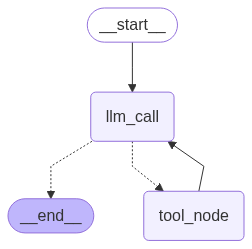

In [13]:
# Build and compile the agent workflow
agent_builder = StateGraph(ToolLoadoutState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, {
    "tool_node": "tool_node",
    END: END,
})
agent_builder.add_edge("tool_node", "llm_call")

agent = agent_builder.compile(store=store)

# Visualize the workflow
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [14]:
# Run the agent on a user query
from utils import format_messages
from langchain_core.messages import HumanMessage

query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": [HumanMessage(content=query)]})



I0000 00:00:1754316072.800295 53712873 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


In [15]:
result

{'messages': [HumanMessage(content='Use available tools to calculate arc cosine of 0.5.', additional_kwargs={}, response_metadata={}, id='61a1e1c2-d4dc-4668-a2cd-60b3df886997'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'acos', 'arguments': '{"x": 0.5}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--4f7578b1-8be3-41e9-9cd4-8f67b5c10cc3-0', tool_calls=[{'name': 'acos', 'args': {'x': 0.5}, 'id': 'ac4ada00-3b68-40bf-be60-69d31f2417a6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 154, 'output_tokens': 3, 'total_tokens': 157, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='1.0471975511965976', id='5c8ed613-9835-4d5f-8dfa-d6142dfbf97b', tool_call_id='ac4ada00-3b68-40bf-be60-69d31f2417a6'),
  AIMessage(content='The arc cosine of 0.5 is 1.0471975511965976 radians.', additional_kwargs={}, response_metadata={'prom

In [16]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use available tools to calculate arc cosine of 0.5.                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: acos                                                                                              │
│    Args: {                                                                                                      │
│   "x": 0.5                                                                                                      │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 1.0471975511965976                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The arc cosine of 0.5 is 1.0471975511965976 radians.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Checkout the [trace](https://smith.langchain.com/public/5183fb52-151d-474a-9220-767c1ef2303c/r)